### EDA - анализ


In [1]:
# Импортируем необходимые библиотеки для работы с данными
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from pandas.errors import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=(FutureWarning, SettingWithCopyWarning))

In [2]:
# Получаем искомые DataFrame'ы
registrations = pd.read_csv('registrations.csv')
persents = pd.read_csv('persents.csv')
payments = pd.read_csv('payments.csv')
advertising_budget = pd.read_excel('advertising_budget.xlsx')

# И сразу создадим копии на всякий случай, чтобы оригиналы осталисьв нетронутом виде если к ним придётся откатиться
registrations_copy = registrations.copy()
persents_copy = persents.copy()
payments_copy = payments.copy()
advertising_budget_copy = advertising_budget.copy()

**Проверим каждый датафрейм на пропущенные значения, типы данных, дубликаты, некорректные названия колонок и т. д.**

**Поработаем с датафреймом регистрации аккаунтов**

In [3]:
registrations_copy.head()

,Unnamed: 0,account_id,created_date,campaign
0,0,3842380.0,2021-01-01,BRA_MS1_install
1,1,3842381.0,2021-01-01,NaN
2,2,3842382.0,2021-01-01,NaN
3,3,3842383.0,2021-01-01,NaN
4,4,3842384.0,2021-01-01,BRA_MS1_install


In [4]:
# Пропущенные значения по колонкам
registrations_copy.isna().sum()

Unnamed: 0          0
account_id          3
created_date        0
campaign        52861
dtype: int64

In [5]:
# Видим, что в колонке campaign очень много пропусков (52861)
# разумно предположить что это нейкий органический трафик. Заполним эти пропуски строкой 'organic'
registrations_copy['campaign'] = registrations_copy['campaign'].fillna('organic')

In [6]:
# Типы данных
registrations_copy.dtypes

Unnamed: 0        int64
account_id      float64
created_date     object
campaign         object
dtype: object

In [7]:
# Теперь посмотрим на пропуски в account_id
registrations_sorted = registrations_copy.sort_values(by='Unnamed: 0').reset_index(drop=True) # отсортируем
nan_indices = registrations_sorted[registrations_sorted['account_id'].isnull()].index # узнаем индексы пропущенных значений
neighbors = registrations_sorted.loc[nan_indices.union(nan_indices - 1).union(nan_indices + 1)] # и посмотрим на рядом строящие строки
neighbors

,Unnamed: 0,account_id,created_date,campaign
52736,52736,3895116.0,2021-01-17,RUS_MS1_install
52737,52737,NaN,2021-01-17,organic
52738,52738,3895118.0,2021-01-17,organic
76129,76129,3918510.0,2021-01-26,organic
76130,76130,NaN,2021-01-26,organic
76131,76131,3918512.0,2021-01-26,organic
78463,78463,3920844.0,2021-01-27,organic
78464,78464,NaN,2021-01-27,organic
78465,78465,3920846.0,2021-01-27,organic


**Выше видно ⬆️, что пропущенные значения хоть и в небольшом количестве, но их можно и нужно не терять и не удалять, 
а довольно легко можно интерполировать подставив логически следующий account_id после предыдущей строки, т к айдишники
отсортированы и понятно какого айди не хватает. Сделаем это.**


In [8]:
for idx in nan_indices:
    prev_id = registrations_sorted.loc[idx - 1, 'account_id']
    next_id = registrations_sorted.loc[idx + 1, 'account_id']
    new_id = int((prev_id + next_id) / 2)
    registrations_sorted.loc[idx, 'account_id'] = new_id

In [9]:
# Также удалим сомнительную колонку , которая просто дублирует индексы строк и приведём account_id к целочисленному формату
# (id пользователя не может быть дробным числом) и приведём дату к типу данных datetime
registrations_sorted = registrations_sorted.drop(columns=["Unnamed: 0"])
registrations_sorted["account_id"] = registrations_sorted["account_id"].astype("int64")
registrations_sorted["created_date"] = pd.to_datetime(registrations_sorted["created_date"])

In [10]:
registrations_sorted.dtypes

account_id               int64
created_date    datetime64[ns]
campaign                object
dtype: object

In [11]:
# Проверим наличие дубликатов
registrations_sorted.duplicated().sum()

0

In [12]:
# И получим очищенный датафрейм для дальнейшей работы
registrations_sorted.head()

,account_id,created_date,campaign
0,3842380,2021-01-01,BRA_MS1_install
1,3842381,2021-01-01,organic
2,3842382,2021-01-01,organic
3,3842383,2021-01-01,organic
4,3842384,2021-01-01,BRA_MS1_install


**Теперь платежные системы**

In [13]:
payments_copy.head()

,payment_date,Payment_types,real_cost,account_id
0,2021-01-01 00:00:56,Payment_system_5,9.650000,2907221
1,2021-01-01 00:01:48,Payment_system_5,0.955872,3228373
2,2021-01-01 00:03:42,Payment_system_5,3.026930,318552
3,2021-01-01 00:04:27,Payment_system_2,99.990000,3832817
4,2021-01-01 00:06:41,Payment_system_5,1.432550,7229767


In [14]:
payments_copy.shape

(303614, 4)

In [15]:
# Округлим до 2х знаков после запятой сконвертированную сумму
payments_copy['real_cost'] = payments_copy['real_cost'].round(2)

In [16]:
payments_copy.dtypes

payment_date      object
Payment_types     object
real_cost        float64
account_id         int64
dtype: object

In [17]:
# Приведём дату оплаты к нужному типу данных
payments_copy["payment_date"] = pd.to_datetime(payments_copy["payment_date"])

In [18]:
# Проверим на пропущенные значения
payments_copy.isna().sum()

payment_date     0
Payment_types    0
real_cost        0
account_id       0
dtype: int64

In [19]:
# Проверим на дубликаты
payments_copy.duplicated().sum()

4

In [20]:
# Убедимся , что это дубли и их можно удалить
payments_copy[payments_copy.duplicated(keep=False)]

,payment_date,Payment_types,real_cost,account_id
35707,2021-02-15 14:40:13,Payment_system_3,1.99,1827251
35708,2021-02-15 14:40:13,Payment_system_3,1.99,1827251
43292,2021-02-26 17:35:31,Payment_system_5,45.20,3945214
43293,2021-02-26 17:35:31,Payment_system_5,45.20,3945214
262704,2021-11-15 16:12:44,Payment_system_4,0.47,4720239
262705,2021-11-15 16:12:44,Payment_system_4,0.47,4720239
268377,2021-11-21 03:22:42,Payment_system_2,62.00,8768141
268378,2021-11-21 03:22:42,Payment_system_2,62.00,8768141


In [21]:
# Переименуем тип оплаты и удалим дубли
payments_clean = payments_copy.rename(columns = {'Payment_types': 'payment_types'}).drop_duplicates()
payments_clean.head()

,payment_date,payment_types,real_cost,account_id
0,2021-01-01 00:00:56,Payment_system_5,9.65,2907221
1,2021-01-01 00:01:48,Payment_system_5,0.96,3228373
2,2021-01-01 00:03:42,Payment_system_5,3.03,318552
3,2021-01-01 00:04:27,Payment_system_2,99.99,3832817
4,2021-01-01 00:06:41,Payment_system_5,1.43,7229767


In [22]:
# Посмотрим есть ли некорректные значения типа отрицательной сконвертированной суммы
(payments_clean["real_cost"] < 0).sum()

0

**Теперь комиссии платежных систем**

In [23]:
persents_copy.head()

,Unnamed: 0,Payment_types,"Share, %"
0,0,Payment_system_1,20.7
1,1,Payment_system_2,15.0
2,2,Payment_system_3,58.5
3,3,Payment_system_4,0.0
4,4,Payment_system_5,24.0


In [24]:
persents_copy.dtypes

Unnamed: 0         int64
Payment_types     object
Share, %         float64
dtype: object

In [25]:
# Переименуем некоторые колонки, приводя к одному стилю с другими датафреймами
persents_copy = persents_copy.rename(columns = {'Payment_types': 'payment_types', 
                                                'Share, %': 'share_in_percentage'})

In [26]:
# Удалим не нужную колонку
persents_clean = persents_copy.drop(columns=["Unnamed: 0"])

In [27]:
persents_clean

,payment_types,share_in_percentage
0,Payment_system_1,20.7
1,Payment_system_2,15.0
2,Payment_system_3,58.5
3,Payment_system_4,0.0
4,Payment_system_5,24.0


***Далее посмотрим на рекламный бюджет***

In [28]:
advertising_budget_copy

,media_source,Campaign_type,Target,"Plan, USD",Installs,"Spend, USD","Deviation, USD"
0,Media_source_1,install,Brazil,100,10460,99.12,0.88
1,NaN,purchase,Brazil,400,1081,398.67,1.33
2,NaN,install,Russia,200,11894,246.30,-46.30
3,NaN,purchase,Russia,500,1441,616.77,-116.77
4,NaN,install,Ukrane,100,6424,99.43,0.57
5,NaN,purchase,Ukrane,500,242,348.13,151.87
6,Media_source_2,install,Brazil,100,152,81.15,18.85
7,NaN,install,English_speaking,100,371,99.95,0.05
8,Total,NaN,NaN,2000,32065,1989.52,10.48


In [29]:
advertising_budget_copy.dtypes

media_source       object
Campaign_type      object
Target             object
Plan, USD           int64
Installs            int64
Spend, USD        float64
Deviation, USD    float64
dtype: object

In [30]:
# В рекламном бюджете просто переименуем колонки
advertising_budget_clean = advertising_budget_copy.rename(columns= {'Campaign_type': 'campaign_type',
                                                                    'Target': 'target',
                                                                    'Plan, USD': 'plan_usd',
                                                                    'Installs': 'installs',
                                                                    'Spend, USD': 'spend_usd',
                                                                    'Deviation, USD': 'deviation_usd'})
advertising_budget_clean

,media_source,campaign_type,target,plan_usd,installs,spend_usd,deviation_usd
0,Media_source_1,install,Brazil,100,10460,99.12,0.88
1,NaN,purchase,Brazil,400,1081,398.67,1.33
2,NaN,install,Russia,200,11894,246.30,-46.30
3,NaN,purchase,Russia,500,1441,616.77,-116.77
4,NaN,install,Ukrane,100,6424,99.43,0.57
5,NaN,purchase,Ukrane,500,242,348.13,151.87
6,Media_source_2,install,Brazil,100,152,81.15,18.85
7,NaN,install,English_speaking,100,371,99.95,0.05
8,Total,NaN,NaN,2000,32065,1989.52,10.48


### Посмотрим на динамику окупаемости рекламных кампаний

#### Объединим датафреймы для пересчёта дохода от рекламных кампаний с учётом комиссий платёжных систем

In [31]:
revenue_by_attraction_channels = (
    registrations_sorted
    .merge(payments_clean, on="account_id", how="left")
    .merge(persents_clean, on="payment_types", how="left")
)
revenue_by_attraction_channels = revenue_by_attraction_channels[revenue_by_attraction_channels['campaign'] != 'organic']

In [32]:
revenue_by_attraction_channels.shape

(36783, 7)

In [33]:
# Видим что есть пропущенные значения, это говорит о том , что у нас есть пользователи зарегистрированные в январе , но не совершавшие оплат
revenue_by_attraction_channels

,account_id,created_date,campaign,payment_date,payment_types,real_cost,share_in_percentage
0,3842380,2021-01-01,BRA_MS1_install,NaT,NaN,NaN,NaN
4,3842384,2021-01-01,BRA_MS1_install,NaT,NaN,NaN,NaN
9,3842389,2021-01-01,RUS_MS1_install,NaT,NaN,NaN,NaN
11,3842391,2021-01-01,UKR_MS1_install,NaT,NaN,NaN,NaN
19,3842399,2021-01-01,BRA_MS1_install,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...
94769,3931503,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN
94774,3931508,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN
94775,3931509,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN
94780,3931514,2021-01-31,BRA_MS1_install,NaT,NaN,NaN,NaN


In [34]:
# Добавим колонку с пересчётом платежей с учётом комиссий платёжных систем
revenue_by_attraction_channels["real_cost_adjusted"] = revenue_by_attraction_channels["real_cost"] * (1 - revenue_by_attraction_channels["share_in_percentage"] / 100)

In [35]:
# Отфильтруем чтобы сначала выводились не пропуски, а оплаты
payments_sorted = revenue_by_attraction_channels.sort_values(by="real_cost", ascending=False, na_position="last")
payments_sorted

,account_id,created_date,campaign,payment_date,payment_types,real_cost,share_in_percentage,real_cost_adjusted
81780,3919398,2021-01-26,BRA_MS1_purchase,2021-05-21 17:48:53,Payment_system_5,67.25,24.0,51.1100
84192,3921730,2021-01-27,BRA_MS1_purchase,2021-06-19 15:04:36,Payment_system_2,49.12,15.0,41.7520
84191,3921730,2021-01-27,BRA_MS1_purchase,2021-06-14 01:09:28,Payment_system_2,48.88,15.0,41.5480
84190,3921730,2021-01-27,BRA_MS1_purchase,2021-06-13 21:07:09,Payment_system_2,48.84,15.0,41.5140
70173,3908313,2021-01-22,UKR_MS1_purchase,2021-11-15 01:40:14,Payment_system_5,48.74,24.0,37.0424
...,...,...,...,...,...,...,...,...
94769,3931503,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN,NaN
94774,3931508,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN,NaN
94775,3931509,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN,NaN
94780,3931514,2021-01-31,BRA_MS1_install,NaT,NaN,NaN,NaN,NaN


In [36]:
payments_sorted['real_cost_adjusted'] = payments_sorted['real_cost_adjusted'].round(2)

In [37]:
# Перемещаем payment_date после created_date
cols = payments_sorted.columns.tolist()
cols.insert(cols.index("created_date") + 1, cols.pop(cols.index("payment_date")))
# Применяем новый порядок
payments_sorted = payments_sorted[cols]

In [38]:
payments_sorted.head()

,account_id,created_date,payment_date,campaign,payment_types,real_cost,share_in_percentage,real_cost_adjusted
81780,3919398,2021-01-26,2021-05-21 17:48:53,BRA_MS1_purchase,Payment_system_5,67.25,24.0,51.11
84192,3921730,2021-01-27,2021-06-19 15:04:36,BRA_MS1_purchase,Payment_system_2,49.12,15.0,41.75
84191,3921730,2021-01-27,2021-06-14 01:09:28,BRA_MS1_purchase,Payment_system_2,48.88,15.0,41.55
84190,3921730,2021-01-27,2021-06-13 21:07:09,BRA_MS1_purchase,Payment_system_2,48.84,15.0,41.51
70173,3908313,2021-01-22,2021-11-15 01:40:14,UKR_MS1_purchase,Payment_system_5,48.74,24.0,37.04


In [39]:
payments_sorted["payment_date"] = payments_sorted["payment_date"].dt.date

In [40]:
# Отберём те строки, в которых дата оплаты больше даты создания аккаунта, потому как не может быть оплаты раньше регистрации
payments_sorted = payments_sorted.query('payment_date >= created_date')

In [41]:
# Считаем доход по кампаниям
revenue_by_campaign = payments_sorted.groupby('campaign', as_index=False) \
                                     .agg({'real_cost_adjusted': 'sum'}) \
                                     .rename(columns={'real_cost_adjusted': 'revenue'}) \
                                     .sort_values('revenue', ascending=False)

In [42]:
revenue_by_campaign

,campaign,revenue
8,UKR_MS1_purchase,997.26
6,RUS_MS1_purchase,822.16
5,RUS_MS1_install,762.89
1,BRA_MS1_purchase,468.53
0,BRA_MS1_install,294.53
7,UKR_MS1_install,107.60
4,PR_youtube_bloger,53.28
3,ENG_MS2_install,25.64
2,BRA_MS2_install,15.21


In [43]:
# Теперь сгруппируем доход от кампаний по датам чтобы понаблюдать динамику
revenue_by_day = payments_sorted.groupby(["campaign", "payment_date"], as_index=False) \
                                .agg({"real_cost_adjusted": "sum"}) \
                                .rename(columns={"real_cost_adjusted": "revenue"}) \
                                .sort_values(["campaign", "payment_date"])


In [44]:
revenue_by_day

,campaign,payment_date,revenue
0,BRA_MS1_install,2021-01-01,14.62
1,BRA_MS1_install,2021-01-03,0.09
2,BRA_MS1_install,2021-01-04,4.24
3,BRA_MS1_install,2021-01-05,0.16
4,BRA_MS1_install,2021-01-12,0.26
...,...,...,...
474,UKR_MS1_purchase,2021-12-06,18.03
475,UKR_MS1_purchase,2021-12-12,34.96
476,UKR_MS1_purchase,2021-12-24,23.01
477,UKR_MS1_purchase,2021-12-25,36.34


In [45]:
# И добавим поле с накопительным доходом для того чтобы в последующем расчитать периоды окупаемости кампаний
revenue_by_day["cumulative_revenue"] = revenue_by_day.groupby("campaign")["revenue"].cumsum()

In [46]:
revenue_by_day

,campaign,payment_date,revenue,cumulative_revenue
0,BRA_MS1_install,2021-01-01,14.62,14.62
1,BRA_MS1_install,2021-01-03,0.09,14.71
2,BRA_MS1_install,2021-01-04,4.24,18.95
3,BRA_MS1_install,2021-01-05,0.16,19.11
4,BRA_MS1_install,2021-01-12,0.26,19.37
...,...,...,...,...
474,UKR_MS1_purchase,2021-12-06,18.03,879.94
475,UKR_MS1_purchase,2021-12-12,34.96,914.90
476,UKR_MS1_purchase,2021-12-24,23.01,937.91
477,UKR_MS1_purchase,2021-12-25,36.34,974.25


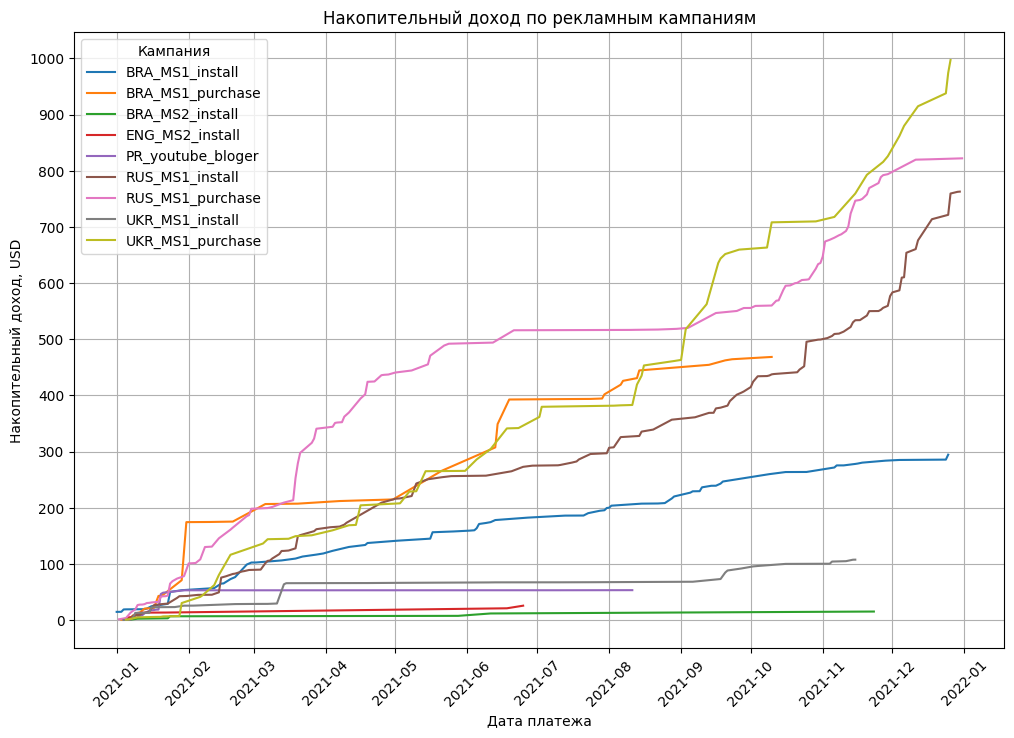

In [47]:
# Визуализируем накопительный доход по кампаниям
plt.figure(figsize=(12, 8))
sns.lineplot(data=revenue_by_day, x="payment_date", y="cumulative_revenue", hue="campaign")

# Устанавливаем метки оси X раз в месяц
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Задаем шаг 100 от 0
y_max = revenue_by_day["cumulative_revenue"].max()
plt.yticks(np.arange(0, y_max + 100, 100))

plt.xticks(rotation=45)
plt.title("Накопительный доход по рекламным кампаниям")
plt.xlabel("Дата платежа")
plt.ylabel("Накопительный доход, USD")
plt.legend(title="Кампания")
plt.grid(True)
plt.savefig("cumulative_revenue_start.png", dpi=300, bbox_inches='tight')
plt.show()

### Расчёт периодов окупаемости

In [48]:
# Создадим датафрем с фактическими затратами на рекламные кампании для дальнейшей работы
spend_data = {
    'campaign': ['BRA_MS1_install', 'BRA_MS1_purchase', 'RUS_MS1_install', 'RUS_MS1_purchase',
                'UKR_MS1_install', 'UKR_MS1_purchase', 'BRA_MS2_install', 'ENG_MS2_install'],
    'spend_usd': [99.12, 398.67, 246.3, 616.77, 99.43, 348.13, 81.15, 99.95] 
}
df_spend = pd.DataFrame(spend_data)
df_spend

,campaign,spend_usd
0,BRA_MS1_install,99.12
1,BRA_MS1_purchase,398.67
2,RUS_MS1_install,246.30
3,RUS_MS1_purchase,616.77
4,UKR_MS1_install,99.43
5,UKR_MS1_purchase,348.13
6,BRA_MS2_install,81.15
7,ENG_MS2_install,99.95


In [49]:
# Объединим датафремы с затратами и доходом
revenue_and_spend = revenue_by_day.merge(df_spend, on = 'campaign', how = 'left')
revenue_and_spend

,campaign,payment_date,revenue,cumulative_revenue,spend_usd
0,BRA_MS1_install,2021-01-01,14.62,14.62,99.12
1,BRA_MS1_install,2021-01-03,0.09,14.71,99.12
2,BRA_MS1_install,2021-01-04,4.24,18.95,99.12
3,BRA_MS1_install,2021-01-05,0.16,19.11,99.12
4,BRA_MS1_install,2021-01-12,0.26,19.37,99.12
...,...,...,...,...,...
474,UKR_MS1_purchase,2021-12-06,18.03,879.94,348.13
475,UKR_MS1_purchase,2021-12-12,34.96,914.90,348.13
476,UKR_MS1_purchase,2021-12-24,23.01,937.91,348.13
477,UKR_MS1_purchase,2021-12-25,36.34,974.25,348.13


In [50]:
# Фильтруем строки, где накопительный доход превысил или сравнялся с затратами
break_even = revenue_and_spend[revenue_and_spend['cumulative_revenue'] >= revenue_and_spend['spend_usd']]

# Для каждой кампании берём первую такую строку
break_even_first = break_even.groupby('campaign').first().sort_values('payment_date').reset_index()
break_even_first

,campaign,payment_date,revenue,cumulative_revenue,spend_usd
0,BRA_MS1_install,2021-02-28,3.59,102.47,99.12
1,RUS_MS1_install,2021-05-15,7.51,250.73,246.30
2,UKR_MS1_purchase,2021-07-02,19.79,361.70,348.13
3,BRA_MS1_purchase,2021-07-30,7.43,401.95,398.67
4,UKR_MS1_install,2021-10-16,3.73,100.03,99.43
5,RUS_MS1_purchase,2021-10-29,18.86,625.65,616.77


In [51]:
# Преобразуем строку в дату
start_date = pd.to_datetime('2021-01-01')

break_even_first['payment_date'] = pd.to_datetime(break_even_first['payment_date'])

# Вычисляем количество дней до окупаемости
break_even_first['payback_period_days'] = (break_even_first['payment_date'] - start_date).dt.days

# Функция, возвращающая разницу в виде (месяцы, дни)
def get_months_days(start, end):
    rd = relativedelta(end, start)
    return f"{rd.years * 12 + rd.months} мес. {rd.days} дн."

# Применим её к твоему датафрейму
break_even_first['payback_period_month'] = break_even_first['payment_date'].apply(
    lambda x: get_months_days(pd.to_datetime("2021-01-01"), x)
)
# Получаем искомые периоды окупаемости рекламных кампаний
payback_periods = break_even_first[['campaign', 'payback_period_days', 'payback_period_month']] \
                  .rename(columns = {'campaign': 'кампания', 'payback_period_days': 'период окупаемости в днях', 'payback_period_month' : 'период окупаемости в месяцах'}) 
payback_periods

,кампания,период окупаемости в днях,период окупаемости в месяцах
0,BRA_MS1_install,58,1 мес. 27 дн.
1,RUS_MS1_install,134,4 мес. 14 дн.
2,UKR_MS1_purchase,182,6 мес. 1 дн.
3,BRA_MS1_purchase,210,6 мес. 29 дн.
4,UKR_MS1_install,288,9 мес. 15 дн.
5,RUS_MS1_purchase,301,9 мес. 28 дн.


In [52]:
# Фильтруем нужные кампании, которые впринципе окупились
selected_campaigns = [
    'BRA_MS1_install',
    'BRA_MS1_purchase',
    'RUS_MS1_install',
    'RUS_MS1_purchase',
    'UKR_MS1_install',
    'UKR_MS1_purchase'
]

# Убедимся, что payment_date — это datetime
revenue_and_spend['payment_date'] = pd.to_datetime(revenue_and_spend['payment_date'])

filtered_df = revenue_and_spend[
    (revenue_and_spend['campaign'].isin(selected_campaigns)) &
    (revenue_and_spend['payment_date'] <= '2021-10-30')
]

# Для удобства объединим с revenue_and_spend, чтобы получить cumulative_revenue на нужную дату
markers = revenue_and_spend.merge(
    break_even_first[['campaign', 'payment_date']], 
    on=['campaign', 'payment_date'], 
    how='inner'
)


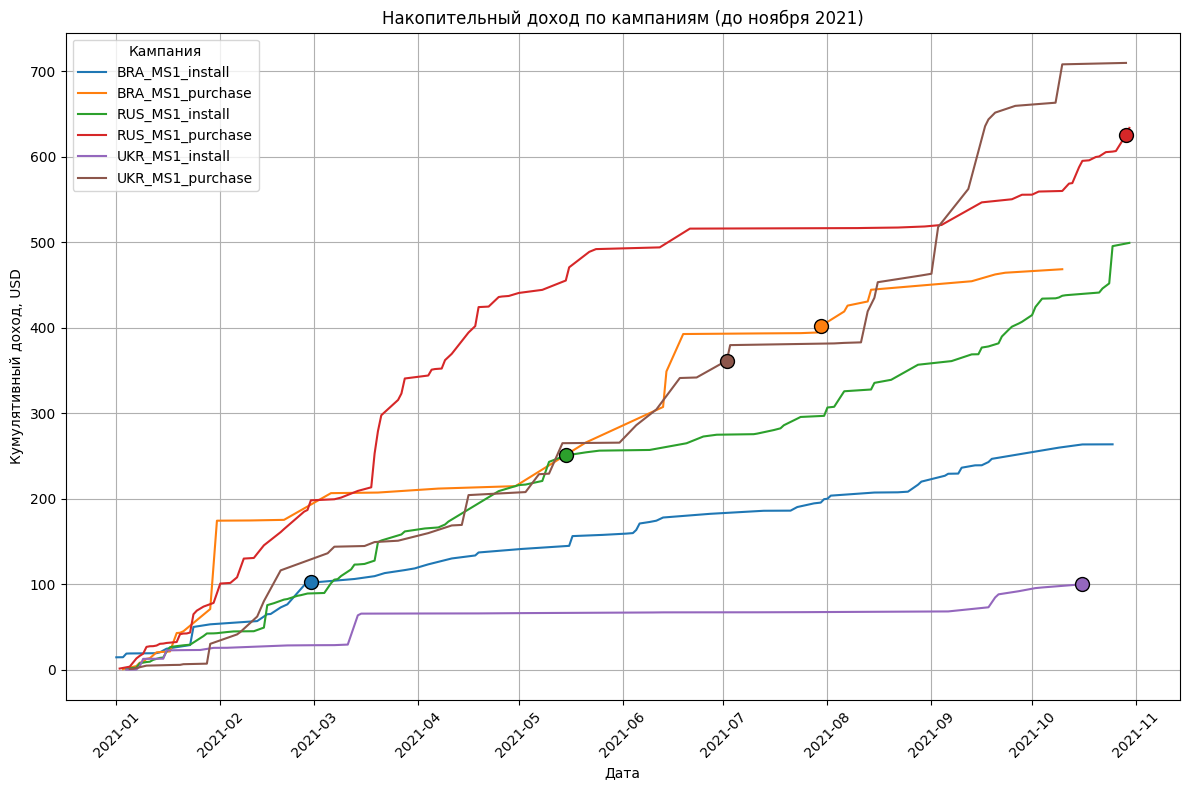

In [53]:
# Строим график
plt.figure(figsize=(12, 8))

palette = sns.color_palette("tab10", n_colors=len(selected_campaigns))
color_dict = dict(zip(selected_campaigns, palette))

sns.lineplot(
    data=filtered_df,
    x='payment_date',
    y='cumulative_revenue',
    hue='campaign',
    palette=color_dict
)

# Устанавливаем метки оси X раз в месяц
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Задаем шаг 100 от 0
y_max = revenue_by_day["cumulative_revenue"].max()
plt.yticks(np.arange(0, y_max + 100, 100))

# Точки
for _, row in markers.iterrows():
    plt.scatter(
        row['payment_date'], row['cumulative_revenue'],
        color=color_dict[row['campaign']],  # тот же цвет
        s=100, marker='o', edgecolor='black', zorder=5
    )

plt.title('Накопительный доход по кампаниям (до ноября 2021)')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный доход, USD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Кампания")
plt.grid(True)
plt.savefig("cumulative_revenue.png", dpi=300, bbox_inches='tight')
plt.show()


Как видно из графика и таблицы `payback_periods` наиболее быстро окупается кампания на пользователей из Бразилии, рекламной сети 1, таргетируемая под установку. Что касается оптимизации под покупки , то наиболее успешная кампания на пользователей из Украины, рекламной сети 1.Взглянем на неё более детально в следующем задании.

### Расчитаем накопительные ARPU на 7, 14 и 30 день жизни аккаунтов

In [54]:
payments_sorted['payment_date'] = pd.to_datetime(payments_sorted['payment_date'])

In [55]:
cum_arpu_ukr = payments_sorted.dropna()

# Оставляем только нужную кампанию
cum_arpu_ukr = cum_arpu_ukr[cum_arpu_ukr['campaign'] == 'UKR_MS1_purchase'].sort_values('created_date')

In [56]:
# Cоздадим колонку с количеством дней жизни аккаунта
cum_arpu_ukr['days_since_signup'] = (
    pd.to_datetime(cum_arpu_ukr['payment_date']) - pd.to_datetime(cum_arpu_ukr['created_date'])
).dt.days


In [57]:
cum_arpu_ukr.head()

,account_id,created_date,payment_date,campaign,payment_types,real_cost,share_in_percentage,real_cost_adjusted,days_since_signup
12287,3853617,2021-01-04,2021-01-06,UKR_MS1_purchase,Payment_system_4,0.17,0.0,0.17,2
14335,3855573,2021-01-04,2021-01-05,UKR_MS1_purchase,Payment_system_4,0.17,0.0,0.17,1
12294,3853617,2021-01-04,2021-11-20,UKR_MS1_purchase,Payment_system_5,13.61,24.0,10.34,320
12289,3853617,2021-01-04,2021-03-19,UKR_MS1_purchase,Payment_system_5,6.10,24.0,4.64,74
12293,3853617,2021-01-04,2021-10-29,UKR_MS1_purchase,Payment_system_5,1.10,24.0,0.84,298


In [58]:
# Расчитываем количество пользователей в нашей самой успешной кампании
count_ukr_purchase_users = registrations_sorted.query('campaign == "UKR_MS1_purchase"')['account_id'].count()
count_ukr_purchase_users

260

In [59]:
# Накопительный ARPU на 7-й день жизни аккаунтов
cum_arpu_ukr_7 = (cum_arpu_ukr.query('days_since_signup <= 7').real_cost_adjusted.sum() / count_ukr_purchase_users).round(2)
cum_arpu_ukr_7

0.12

In [60]:
# Накопительный ARPU на 14-й день жизни аккаунтов
cum_arpu_ukr_14 = (cum_arpu_ukr.query('days_since_signup <= 14').real_cost_adjusted.sum() / count_ukr_purchase_users).round(2)
cum_arpu_ukr_14

0.12

In [61]:
# Накопительный ARPU на 30-й день жизни аккаунтов
cum_arpu_ukr_30 = (cum_arpu_ukr.query('days_since_signup <= 30').real_cost_adjusted.sum() / count_ukr_purchase_users).round(2)
cum_arpu_ukr_30

0.45

### Дополнительные метрики для отслеживания эффективности рекламных кампаний

Для того, чтобы отслеживать эффективность и окупаемость рекламных кампаний я выделю следющие:

- **ROI** по месяцам - окупаемость затрат на рекламную кампанию. Расчитав ROI по месяцам можно отслеживать динамику окупаемости инвестиций, не дожидаясь                        полной окупаемости;
- **Conversion** в платящего - также важная метрика, показывающая эффективность кампании, так как нам важно не только сколько трафика мы "налили", а                                    насколько это качественные лиды - сколько мы получаем платящих пользователей по отношению ко всем;
- **CAC** и **ARPPU** - затраты на привлечение одного покупателя или одного платящего пользователя и показатель количества денег от платящих пользователей соответственно, считаю эти 2 метрика полезными для оценки общей картины по окупаемости рекламных кампаний.

In [62]:
# Добавим колонку с месяцем
revenue_and_spend['payment_date'] = pd.to_datetime(revenue_and_spend['payment_date'])
revenue_and_spend['month'] = revenue_and_spend['payment_date'].dt.to_period('M').astype(str)
revenue_and_spend.head()

,campaign,payment_date,revenue,cumulative_revenue,spend_usd,month
0,BRA_MS1_install,2021-01-01,14.62,14.62,99.12,2021-01
1,BRA_MS1_install,2021-01-03,0.09,14.71,99.12,2021-01
2,BRA_MS1_install,2021-01-04,4.24,18.95,99.12,2021-01
3,BRA_MS1_install,2021-01-05,0.16,19.11,99.12,2021-01
4,BRA_MS1_install,2021-01-12,0.26,19.37,99.12,2021-01


In [63]:
# Рассчитываем месячные ROI
monthly_roi = (
    revenue_and_spend \
    .groupby(['campaign', 'month'], as_index=False) \
    .agg({'cumulative_revenue': 'last', 'spend_usd': 'last'})
)
monthly_roi['ROI'] = (monthly_roi['cumulative_revenue'] - monthly_roi['spend_usd']) / monthly_roi['spend_usd'] * 100
monthly_roi

,campaign,month,cumulative_revenue,spend_usd,ROI
0,BRA_MS1_install,2021-01,53.19,99.12,-46.337772
1,BRA_MS1_install,2021-02,102.47,99.12,3.379742
2,BRA_MS1_install,2021-03,118.62,99.12,19.673123
3,BRA_MS1_install,2021-04,137.23,99.12,38.448345
4,BRA_MS1_install,2021-05,157.80,99.12,59.200969
...,...,...,...,...,...
71,UKR_MS1_purchase,2021-08,461.27,348.13,32.499354
72,UKR_MS1_purchase,2021-09,659.63,348.13,89.478069
73,UKR_MS1_purchase,2021-10,709.86,348.13,103.906587
74,UKR_MS1_purchase,2021-11,825.84,348.13,137.221728


In [64]:
# Соберём сводную таблицу
roi_pivot = monthly_roi.pivot_table(
    index='campaign',   # кампании — строки
    columns='month',    # месяцы — колонки
    values='ROI',       # ROI — значения
    aggfunc='last'      # если дубликаты, возьмётся последнее
).round(2)              # округление для читаемости
roi_pivot.columns.name = None
roi_pivot = roi_pivot.ffill(axis=1)
roi_pivot

,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12
campaign,,,,,,,,,,,,
BRA_MS1_install,-46.34,3.38,19.67,38.45,59.20,84.05,101.35,122.05,148.93,166.06,186.36,197.14
BRA_MS1_purchase,-56.25,-56.01,-48.00,-46.12,-33.30,-1.49,0.82,11.50,16.50,17.52,17.52,17.52
BRA_MS2_install,-91.68,-91.68,-91.68,-91.68,-90.71,-85.48,-85.48,-85.48,-85.48,-85.48,-81.26,-81.26
ENG_MS2_install,-86.58,-86.58,-86.58,-86.58,-86.58,-74.35,-74.35,-74.35,-74.35,-74.35,-74.35,-74.35
RUS_MS1_install,-82.61,-63.78,-34.29,-15.15,4.07,11.64,20.60,44.87,65.27,102.80,134.25,209.74
RUS_MS1_purchase,-87.31,-67.86,-44.76,-29.11,-20.22,-16.33,-16.33,-15.93,-9.91,3.08,28.73,33.30
UKR_MS1_install,-74.19,-71.34,-33.93,-33.41,-33.32,-32.43,-32.18,-32.18,-7.57,0.60,8.22,8.22
UKR_MS1_purchase,-91.28,-66.59,-56.63,-41.30,-23.68,-1.79,9.09,32.50,89.48,103.91,137.22,186.46


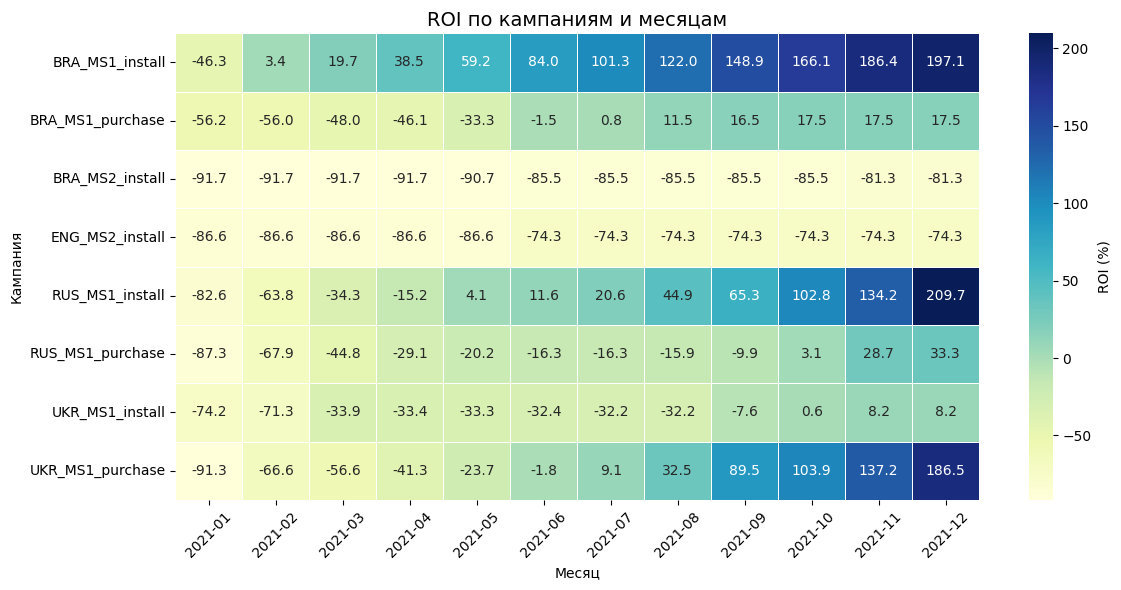

In [65]:
# И визуализируем для наглядности с помощью тепловой карты
plt.figure(figsize=(12, 6))
sns.heatmap(
    roi_pivot,
    annot=True,          # отображать значения внутри ячеек
    fmt=".1f",           # формат значений
    cmap="YlGnBu",       # цветовая схема (можно заменить на "coolwarm", "RdYlGn", "viridis" и др.)
    linewidths=0.5,      # линии между ячейками
    cbar_kws={'label': 'ROI (%)'}  # подпись к цветовой шкале
)

plt.title("ROI по кампаниям и месяцам", fontsize=14)
plt.xlabel("Месяц")
plt.ylabel("Кампания")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("ROI.png", dpi=300, bbox_inches='tight')
plt.show()

Теперь рассчитаем **Conversion**, **CAC** и **ARPPU**

In [66]:
# Подготовим датафрейм
revenue_by_attraction_channels["payment_date"] = revenue_by_attraction_channels["payment_date"].dt.date
revenue_by_attraction_channels = revenue_by_attraction_channels.sort_values(by="real_cost", ascending=False, na_position="last")

In [67]:
# Добавим колонку с булевой меткой платящего и не платящего пользователя
revenue_by_attraction_channels['is_payer'] = revenue_by_attraction_channels['real_cost'].notna() & (revenue_by_attraction_channels['real_cost'] > 0)
revenue_by_attraction_channels

,account_id,created_date,campaign,payment_date,payment_types,real_cost,share_in_percentage,real_cost_adjusted,is_payer
81780,3919398,2021-01-26,BRA_MS1_purchase,2021-05-21,Payment_system_5,67.25,24.0,51.1100,True
84192,3921730,2021-01-27,BRA_MS1_purchase,2021-06-19,Payment_system_2,49.12,15.0,41.7520,True
84191,3921730,2021-01-27,BRA_MS1_purchase,2021-06-14,Payment_system_2,48.88,15.0,41.5480,True
84190,3921730,2021-01-27,BRA_MS1_purchase,2021-06-13,Payment_system_2,48.84,15.0,41.5140,True
70173,3908313,2021-01-22,UKR_MS1_purchase,2021-11-15,Payment_system_5,48.74,24.0,37.0424,True
...,...,...,...,...,...,...,...,...,...
94769,3931503,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN,NaN,False
94774,3931508,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN,NaN,False
94775,3931509,2021-01-31,ENG_MS2_install,NaT,NaN,NaN,NaN,NaN,False
94780,3931514,2021-01-31,BRA_MS1_install,NaT,NaN,NaN,NaN,NaN,False


In [68]:
# Сформируем датафрейм для расчёта метрик
df_metrics = revenue_by_attraction_channels \
          .groupby('campaign') \
          .agg(
                total_users=('account_id', 'nunique'),
                paying_users=('is_payer', 'sum'),
                revenue=('real_cost_adjusted', 'sum')) \
         .reset_index()
df_metrics['revenue'] = df_metrics['revenue'].round(2)
df_metrics = df_metrics[~df_metrics['campaign'].isin(['our_fb', 'PR_youtube_bloger'])]
df_metrics = df_metrics.merge(df_spend, on = 'campaign')
df_metrics

,campaign,total_users,paying_users,revenue,spend_usd
0,BRA_MS1_install,11462,105,300.29,99.12
1,BRA_MS1_purchase,1139,50,468.53,398.67
2,BRA_MS2_install,152,8,15.20,81.15
3,ENG_MS2_install,407,10,25.63,99.95
4,RUS_MS1_install,12649,188,770.58,246.30
5,RUS_MS1_purchase,1581,196,851.01,616.77
6,UKR_MS1_install,6790,52,108.33,99.43
7,UKR_MS1_purchase,260,79,1014.02,348.13


In [69]:
# И расчитаем метрики
df_metrics['conversion'] = (df_metrics['paying_users'] / df_metrics['total_users'] * 100).round(2)
df_metrics['CAC'] = (df_metrics['spend_usd'] / df_metrics['paying_users']).round(2)
df_metrics['ARPPU'] = (df_metrics['revenue'] / df_metrics['paying_users']).round(2)
df_metrics['ROI'] = ((df_metrics['revenue'] - df_metrics['spend_usd']) / df_metrics['spend_usd'] * 100).round(2)
metrics = df_metrics[['campaign', 'conversion', 'CAC', 'ARPPU', 'ROI']] \
          .sort_values(['conversion', 'CAC', 'ARPPU'], ascending = False) \
          .rename(columns = {'campaign': 'кампания'})
metrics

,кампания,conversion,CAC,ARPPU,ROI
7,UKR_MS1_purchase,30.38,4.41,12.84,191.28
5,RUS_MS1_purchase,12.40,3.15,4.34,37.98
2,BRA_MS2_install,5.26,10.14,1.90,-81.27
1,BRA_MS1_purchase,4.39,7.97,9.37,17.52
3,ENG_MS2_install,2.46,10.00,2.56,-74.36
4,RUS_MS1_install,1.49,1.31,4.10,212.86
0,BRA_MS1_install,0.92,0.94,2.86,202.96
6,UKR_MS1_install,0.77,1.91,2.08,8.95


Дополнительные метрики подтверждают, что самые эффективные кампании, оптимизированные под покупку это кампании , таргетируемые на Украину и Россию в рекламной сети 1. Оптимизированные под установку это Бразилия и Россия рекламная кампания 1. А рекламная сеть 2 вообще не достигает окупаемости.

### Статистическое сравнение рекламный кампаний по странам

Так как пользователи из разных стран могут сильно отличаться по поведенческим моделям, покупательской способности и ещё как то, считаю что статистические тесты уместно проводить внутри каждой из стран. Посмотрим с точки зрения статистической значимости как отличаются или не отличаются группы (install и purchase) по **ARPPU** - сравнение средних, применим t-тест Уэлча, не обращая вниманя на гомогенность дисперсий в группах, а также сравним **Conversion** в платящего пользователя - критерий Хи - квадрат. 

In [70]:
# Подготовим группы пользователей для сравнения ARPPU
df_rus = revenue_by_attraction_channels[revenue_by_attraction_channels['campaign'].str.startswith('RUS_MS1')]
df_ukr = revenue_by_attraction_channels[revenue_by_attraction_channels['campaign'].str.startswith('UKR_MS1')]
df_bra = revenue_by_attraction_channels[revenue_by_attraction_channels['campaign'].str.startswith('BRA_MS1')]

# Отфильтруем платящих
rus_install_arppu = df_rus[(df_rus['campaign'].str.contains('install')) & (df_rus['real_cost_adjusted'] > 0)]['real_cost_adjusted']
rus_purchase_arppu = df_rus[(df_rus['campaign'].str.contains('purchase')) & (df_rus['real_cost_adjusted'] > 0)]['real_cost_adjusted']
ukr_install_arppu = df_ukr[(df_ukr['campaign'].str.contains('install')) & (df_ukr['real_cost_adjusted'] > 0)]['real_cost_adjusted']
ukr_purchase_arppu = df_ukr[(df_ukr['campaign'].str.contains('purchase')) & (df_ukr['real_cost_adjusted'] > 0)]['real_cost_adjusted']
bra_install_arppu = df_bra[(df_bra['campaign'].str.contains('install')) & (df_bra['real_cost_adjusted'] > 0)]['real_cost_adjusted']
bra_purchase_arppu = df_bra[(df_bra['campaign'].str.contains('purchase')) & (df_bra['real_cost_adjusted'] > 0)]['real_cost_adjusted']


# T-тест
t_stat_rus, p_value_rus = ttest_ind(rus_install_arppu, rus_purchase_arppu, equal_var=False)  # Welch t-test
t_stat_ukr, p_value_ukr = ttest_ind(ukr_install_arppu, ukr_purchase_arppu, equal_var=False)
t_stat_bra, p_value_bra = ttest_ind(bra_install_arppu, bra_purchase_arppu, equal_var=False)

print(f'RUS ARPPU t-test: t={t_stat_rus:.3f}, p-value={p_value_rus:.4f}')
print(f'UKR ARPPU t-test: t={t_stat_ukr:.3f}, p-value={p_value_ukr:.4f}')
print(f'BRA ARPPU t-test: t={t_stat_bra:.3f}, p-value={p_value_bra:.4f}')

RUS ARPPU t-test: t=-0.376, p-value=0.7070
UKR ARPPU t-test: t=-6.756, p-value=0.0000
BRA ARPPU t-test: t=-3.418, p-value=0.0012


In [71]:
# Также подготовим таблицы сопряженности по группам для применения критерия Хи - квадрат
df_rus.loc[:, 'group'] = df_rus['campaign'].apply(lambda x: 'install' if 'install' in x else 'purchase')
df_ukr.loc[:, 'group'] = df_ukr['campaign'].apply(lambda x: 'install' if 'install' in x else 'purchase')
df_bra.loc[:, 'group'] = df_bra['campaign'].apply(lambda x: 'install' if 'install' in x else 'purchase')

# Подготовим таблицы: платящие / не платящие по группам
contingency_rus = df_rus.groupby('group')['is_payer'].value_counts().unstack().fillna(0)
contingency_ukr = df_ukr.groupby('group')['is_payer'].value_counts().unstack().fillna(0)
contingency_bra = df_bra.groupby('group')['is_payer'].value_counts().unstack().fillna(0)

# Хи-квадрат тест
chi2_rus, p_rus, _, _ = chi2_contingency(contingency_rus)
chi2_ukr, p_ukr, _, _ = chi2_contingency(contingency_ukr)
chi2_bra, p_bra, _, _ = chi2_contingency(contingency_bra)

print(f'RUS χ² тест конверсии: χ²={chi2_rus:.2f}, p-value={p_rus:.4f}')
print(f'UKR χ² тест конверсии: χ²={chi2_ukr:.2f}, p-value={p_ukr:.4f}')
print(f'BRA χ² тест конверсии: χ²={chi2_bra:.2f}, p-value={p_bra:.4f}')

RUS χ² тест конверсии: χ²=571.80, p-value=0.0000
UKR χ² тест конверсии: χ²=931.56, p-value=0.0000
BRA χ² тест конверсии: χ²=96.87, p-value=0.0000


Статистические критерии показали отсутствие статистически значимых отличий только в **ARPPU** по России, в остальном все тесты показали статистически значимые отличия в каналах `install` и `purchase`. Хотя **ROI** некоторых каналов `install` довольно большой, а пользователей по этим каналам привлечено гораздо больше , чем по каналам `purchase`, всё таки каналы привлечения `purchase` дают более качественных лидов, которые гораздо лучше конвертируются в платящих пользователей, которые платят больше. 